In [61]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt
import os

In [4]:
os.chdir("C:\\Users\\aakan\\Downloads")

In [5]:
img_size=256
batchsize=32
channels=3
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "potato_disease",
    shuffle=True,
    image_size=(img_size,img_size),
    batch_size=32)

Found 2152 files belonging to 3 classes.


In [6]:
class_names=dataset.class_names

In [7]:
len(dataset) #length basically the number of batch and since we have given batch size as 32 32*68=2175 approx. as that of 2152,try with diff batch size

68

In [8]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())     #converted to numpy as the value will be in tensor
# the 3 in o/p is channels 

(32, 256, 256, 3)
[1 0 1 1 0 2 0 0 0 0 0 1 0 1 0 1 1 1 0 0 0 0 1 0 0 2 1 0 1 0 0 0]


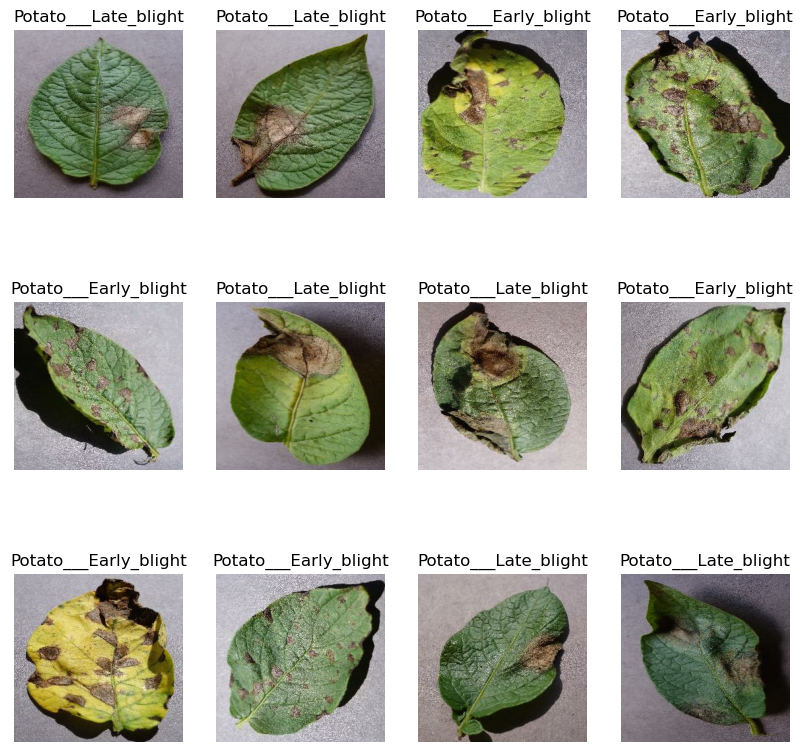

In [10]:
#visualizing the image
plt.figure(figsize=(10,10))
for image_batch,label_batch in dataset.take(1):     #just taking 1 batch 
    for i in range(1,13):    #displaying 12 images
        plt.subplot(3,4,i) 
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [11]:
# we will use 80% training
# 10% validation , 10% test

In [12]:
#training 80% of 68==54
train_ds=dataset.take(54)
len(train_ds)

54

In [13]:
test_ds=dataset.skip(54)
len(test_ds)

14

In [14]:
#validation 
val_size=0.1
val_ds=test_ds.take(6)

In [15]:
#test dataset
test_ds=test_ds.skip(6)
len(test_ds)

8

In [16]:
#using the function to perform train test split above we had done it manually
def get_dataset_partitions(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000):
    ds_size=len(ds)
    
    if shuffle:                           #shuffling and seed value can be anything 
        ds=ds.shuffle(shuffle_size,seed=12)
        
    train_size=int(train_split*ds_size)
    val_size=int(val_split*ds_size)
    
    train_ds=ds.take(train_size)
    
    val_ds=ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [17]:
train_ds,val_ds,test_ds=get_dataset_partitions(dataset)

In [18]:
#caching , storing
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)    #cache basically saves the image so that machine does not keep on reading it again both are used to save time
val_ds= val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [19]:
resize_and_rescale=tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(img_size,img_size),
    layers.experimental.preprocessing.Rescaling(1.0/255),
])

In [20]:
#data augmentation it basically creates 4 more training images of the main image, rotated(horizontal and vertical, contrast,zoom 
# so that it adapts to predicting
data_aug=resize_and_rescale=tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),])

In [21]:
#Using Convolutinal neural network

In [22]:
input_shape=(batchsize,img_size,img_size,channels)
n_classes=3
model=models.Sequential([
    resize_and_rescale,
    data_aug,
    layers.Conv2D(32,(3,3),activation='relu',input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),  
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(n_classes,activation='softmax')
])
model.build(input_shape=input_shape)

In [23]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [24]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [31]:
history=model.fit( train_ds,
          epochs=50,    #more the epoch more will be the accuracy,
          batch_size=batchsize,
          verbose=1,
         validation_data=val_ds)

Epoch 1/5
54/54 [==============================] - 66s 1s/step - loss: 0.2228 - accuracy: 0.9097 - val_loss: 0.3475 - val_accuracy: 0.8646
Epoch 2/5
54/54 [==============================] - 59s 1s/step - loss: 0.2355 - accuracy: 0.9091 - val_loss: 0.2046 - val_accuracy: 0.9062
Epoch 3/5
54/54 [==============================] - 54s 998ms/step - loss: 0.1741 - accuracy: 0.9277 - val_loss: 0.2198 - val_accuracy: 0.9062
Epoch 4/5
54/54 [==============================] - 58s 1s/step - loss: 0.1512 - accuracy: 0.9416 - val_loss: 0.2561 - val_accuracy: 0.8802
Epoch 5/5
54/54 [==============================] - 70s 1s/step - loss: 0.1803 - accuracy: 0.9253 - val_loss: 0.2266 - val_accuracy: 0.8854


In [26]:
#Ignore just a code to check if gpu is there or not
"""import tensorflow as tf
gpus = tf.config.list_physical_devices("GPU")
if gpus:
    for gpu in gpus:
        print("Found a GPU with the name:", gpu)
else:
    print("Failed to detect a GPU.")
"""

Failed to detect a GPU.


In [35]:
scores= model.evaluate(test_ds)
scores

8/8 [==============================] - 2s 192ms/step - loss: 0.1253 - accuracy: 0.9414


[0.1252634972333908, 0.94140625]

In [36]:
#seeing the attributes of the model
history

In [37]:
history.params

{'verbose': 1, 'epochs': 5, 'steps': 54}

In [38]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [39]:
history.history['accuracy']

[0.9097222089767456,
 0.9091435074806213,
 0.9276620149612427,
 0.9415509104728699,
 0.9253472089767456]

In [40]:
acc= history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

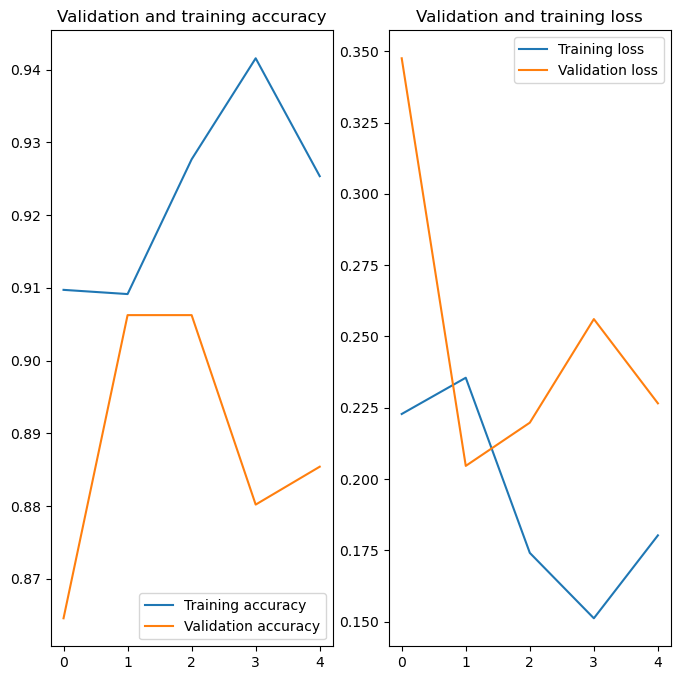

In [45]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(5),acc,label='Training accuracy')
plt.plot(range(5), val_acc,label='Validation accuracy')
plt.legend(loc='lower right')
plt.title('Validation and training accuracy')

plt.subplot(1,2,2)
plt.plot(range(5),loss,label='Training loss')   #5 is the number of epochs
plt.plot(range(5), val_loss,label='Validation loss')
plt.legend(loc='upper right')
plt.title('Validation and training loss')
plt.show()


In [84]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 64)       

First Image to predict 
first image's actual label: Potato___Early_blight
1/1 [==============================] - 0s 356ms/step
[[9.9845445e-01 1.5455178e-03 8.4131618e-11]
 [1.7743004e-06 9.9999821e-01 1.4711749e-14]
 [9.9997258e-01 2.7469232e-05 1.2813155e-20]
 [9.1023070e-01 8.9688919e-02 8.0383288e-05]
 [1.0231182e-02 9.8976851e-01 2.9298960e-07]
 [9.0317780e-01 9.6709043e-02 1.1318333e-04]
 [5.0074643e-01 4.8574263e-01 1.3510936e-02]
 [7.3176994e-07 4.9496051e-03 9.9504966e-01]
 [1.0000000e+00 6.8528374e-09 1.2410416e-13]
 [9.6481729e-01 3.3664476e-02 1.5182440e-03]
 [9.9978453e-01 2.0048780e-04 1.4987651e-05]
 [9.9996233e-01 3.5447694e-05 2.3129135e-06]
 [9.9999952e-01 4.9704659e-07 1.6451253e-17]
 [5.1839021e-04 9.9946696e-01 1.4705656e-05]
 [1.0761044e-03 9.9892384e-01 9.9168965e-11]
 [1.2525449e-02 9.8747408e-01 4.7724120e-07]
 [2.0665441e-02 9.5749074e-01 2.1843778e-02]
 [2.0651672e-04 9.9797863e-01 1.8148369e-03]
 [7.2605693e-04 9.9927372e-01 1.7734286e-07]
 [6.3841371e-04 9.

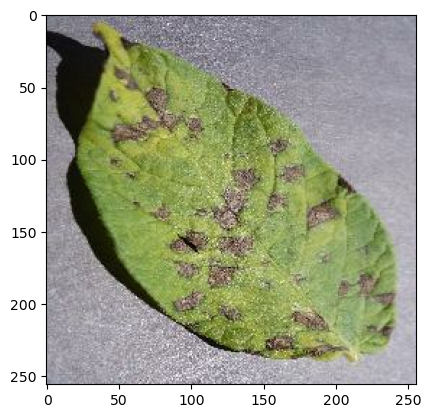

In [102]:
#performing prediction
for images_batch, labels_batch in test_ds.take(1):
    # print(images_batch[0]) its tensor value
    first_image=images_batch[0].numpy().astype('uint8') # converted to 3d array format
    #plt.imshow(first_image)
    first_label=labels_batch[0].numpy()
    
    print('First Image to predict ')
    plt.imshow(first_image)
    print("first image's actual label:",class_names[first_label])
    
    batch_prediction=model.predict(images_batch)
    #print(batch_prediction)
    #print(batch_prediction[0]) #the predcition value of the first image and in this maximum value of this array will be the class the leaf will belong to
    print("Predicted label:", class_names[np.argmax(batch_prediction[0])])

In [114]:
# the function to predict the class of leaf
def predict(model,img):
    img_array=tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array=tf.expand_dims(img_array,0) #created a batch
    
    prediction=model.predict(img_array)
    predicted_classofleaf=class_names[np.argmax(prediction[0])]
    confidence=round(100*(np.max(prediction[0])),2)
    return predicted_classofleaf,confidence

1/1 [==============================] - 0s 42ms/step


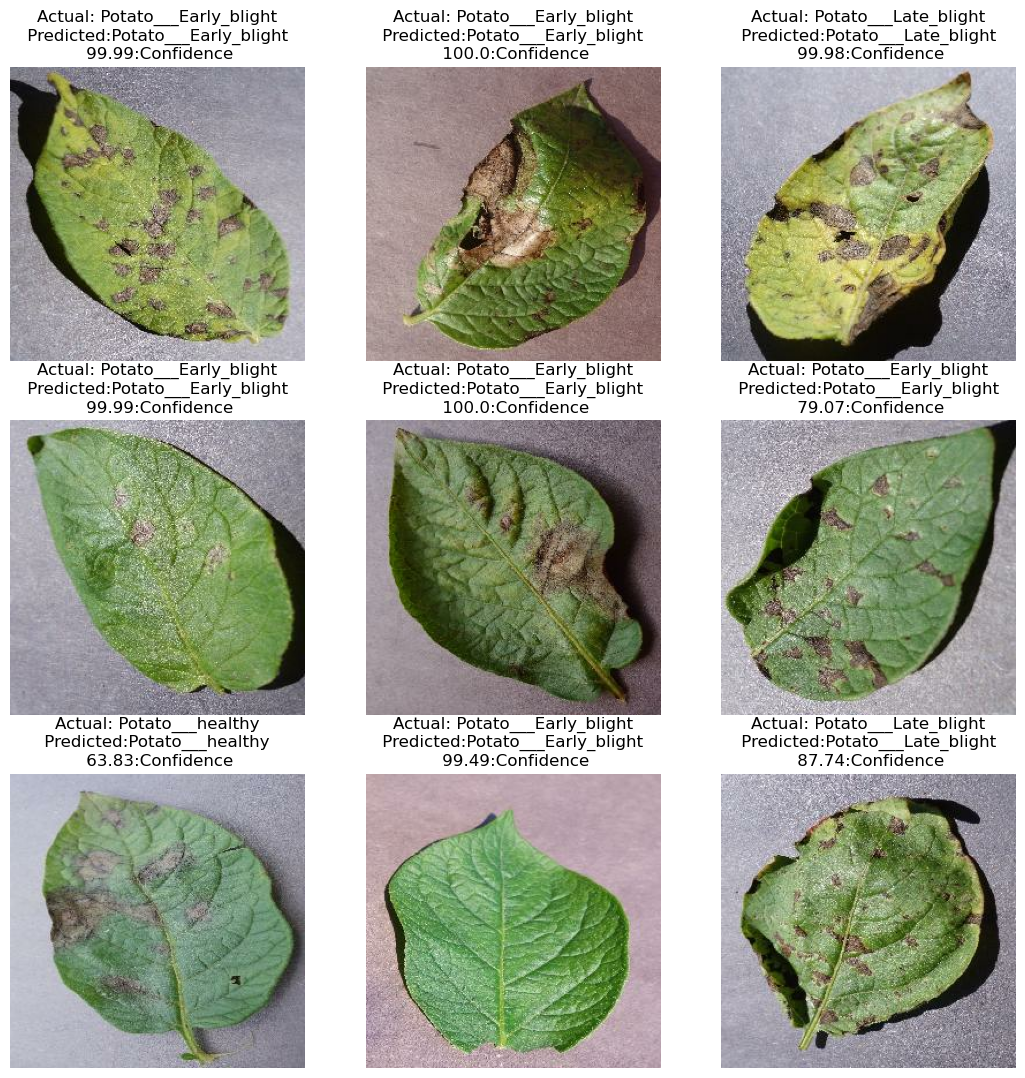

In [127]:
#performing prediction on 9 images 
plt.figure(figsize=(13,13))
for images, labels in test_ds.take(1):
    for i in range(9):
        plt.subplot(3,3,i+1)
        plt.imshow(images_batch[i].numpy().astype('uint8'))
        predicted_classofleaf,confidence=predict(model,images[i].numpy())
        actual_class=class_names[labels[i]]
        plt.title(f'Actual: {actual_class}\n Predicted:{predicted_classofleaf} \n {confidence}:Confidence')
        plt.axis('off')

In [130]:
#saving this image classfication model
model_name='CNN img classif'
model.save(f"C://Users//aakan//Desktop//data_models/{model_name}")

INFO:tensorflow:Assets written to: C://Users//aakan//Desktop//data_models/CNN img classif/assets


INFO:tensorflow:Assets written to: C://Users//aakan//Desktop//data_models/CNN img classif/assets
